In [1]:
import torch
import numpy as np
import imageio
import matplotlib.pyplot as plt
import os
from torch.utils.data import DataLoader
from dataset import get_rays
from rendering import rendering
import torch.nn as nn
from ml_helpers import training
from model import Voxel, NeRF

# Camera

In [3]:
o, d, target_px_values = get_rays('ganesha', mode='train')
o.shape

MemoryError: Unable to allocate 10.9 GiB for an array with shape (39, 12484800, 3) and data type float64

In [9]:
batch_size = 1024

o, d, target_px_values = get_rays('ganesha', mode='train')
dataloader_warmup = DataLoader(torch.cat((
    torch.from_numpy(o).reshape(100, 720, 1280, 3)[:, 300:900, 300:900,:].reshape(-1, 3).type(torch.float),
    torch.from_numpy(d).reshape(100, 720, 1280, 3)[:, 300:900, 300:900,:].reshape(-1, 3).type(torch.float),
    torch.from_numpy(target_px_values).reshape(100, 720, 1280, 3)[:, 300:900, 300:900,:].reshape(-1, 3).type(torch.float)), dim=1),
    batch_size=batch_size, shuffle=True)
    
dataloader = DataLoader(torch.cat((
    torch.from_numpy(o).reshape(-1, 3).type(torch.float),
    torch.from_numpy(d).reshape(-1, 3).type(torch.float),
    torch.from_numpy(target_px_values).reshape(-1, 3).type(torch.float)), dim=1),
    batch_size=batch_size, shuffle=True)


# test_o, test_d, target_px_values = get_rays('fox', mode='train')

KeyError: 'v2 unknown unknown 1280 720 perspective 0'

# Training

100%|██████████| 24610/24610 [36:43<00:00, 11.17it/s]


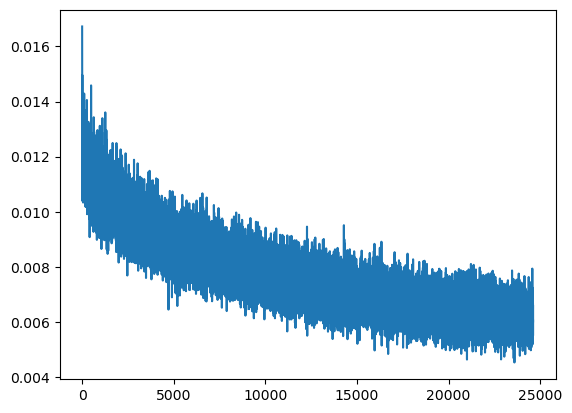

100%|██████████| 90000/90000 [2:21:42<00:00, 10.59it/s]  


In [7]:
device = 'cuda'

nb_epochs=1
lr=1e-3
gamma=0.5 
tn = 8
tf = 12
nb_bins = 100


model = NeRF().to(device)
optimizer= torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 10], gamma=gamma)

training_l_warm = training(model, optimizer, scheduler, tn, tf, nb_bins, 1, dataloader_warmup, device)
plt.plot(training_l_warm)
plt.show()
training_loss = training(model, optimizer, scheduler, tn, tf, nb_bins, nb_epochs, dataloader, device)

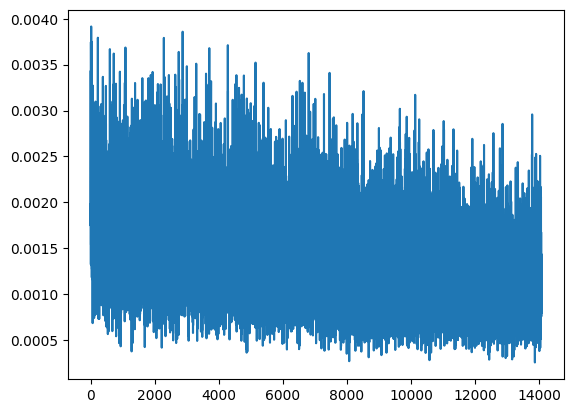

In [5]:
plt.plot(training_loss)

In [7]:
rand_list = np.random.randint(low=0, high=80, size=10)

for ind in rand_list:
    img = rendering(model, torch.from_numpy(o[ind]).to(device), torch.from_numpy(d[ind]).to(device), tn, tf, nb_bins=100, device=device)
    plt.imshow(img.reshape(400, 400, 3).data.cpu().numpy())
    plt.show()

OutOfMemoryError: CUDA out of memory. Tried to allocate 7.51 GiB. GPU 0 has a total capacity of 6.00 GiB of which 0 bytes is free. Of the allocated memory 7.90 GiB is allocated by PyTorch, and 56.69 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [8]:
torch.save(model, "model_nerf_bottle")